# AQI PREDICTION MODEL

## Aim for this Notebook:
1. Training different models to predict AQI (RandomForest, SVM, XGBoost, Stacking model using Ensemble Learning)
2. Checking data for any type of Noise like **Skewness, Null values, dublicate Values, correlation**
3. Using differnt performance matrics to evaluate the accuracy of the model.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
import scipy.stats as stats

# Loading the dataset
## About Dataset:
1. Dataset is taken from kaggle, it is a daily AQI of city Kolkata.
2. Dataset is comprised of **13 features** like **StationId, Date, PM2.5, PM10, NO, NO2, NOx, NH3, CO, SO2, O3, Benzene, Toluene, Xylene, AQI and AQI_Bucket.**
3. We have main **9 features** of **pollutants* that are responsible of AQI Prediction, these will be our independent variables and used in model training.
4. This is huge dataset **consisting of 1,08,085 rows**.

In [2]:
df=pd.read_csv('data.csv')
df.head()

,StationId,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,AP001,2017-11-24,71.36,115.75,1.75,20.65,12.40,12.19,0.10,10.76,109.26,0.17,5.92,0.10,NaN,NaN
1,AP001,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2,AP001,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
3,AP001,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
4,AP001,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate


## Checking for the Missing Values percentage in each feature of the dataset

In [3]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)

           column_name  percent_missing
StationId    StationId         0.000000
Date              Date         0.000000
PM2.5            PM2.5        20.016661
PM10              PM10        39.529782
NO                  NO        15.833758
NO2                NO2        15.316333
NOx                NOx        14.347202
NH3                NH3        44.527237
CO                  CO        12.031286
SO2                SO2        23.329477
O3                  O3        23.666404
Benzene        Benzene        29.115564
Toluene        Toluene        35.823576
Xylene          Xylene        78.805017
AQI                AQI        19.447401
AQI_Bucket  AQI_Bucket        19.447401


## Observation:

1. There are huge number of missing values in the dataset mainly in **Xylene, NH3, PM10, Benzene**, from this we conclude that we cannot remove the data points with missing values that will cost loss of much data.

## Approach:

1. Removing the whole Xylene feature because it has more than 75% of missing values which cannot be entertained.
2. Removing the dataset from the features having less number of missing values and duplicate values. (This will also decrease the amount of the missing values from the features having higher number of missing values, later that can be omitted by mean)

In [4]:
df.drop_duplicates()
df.dropna(subset=['AQI','PM2.5','NO','NO2','NOx','CO'],inplace=True)
df=df.drop('Xylene',axis=1)
df.fillna({col: df[col].mean() for col in ['PM10', 'NH3', 'SO2','O3','Benzene','Toluene']}, inplace=True)
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)

           column_name  percent_missing
StationId    StationId              0.0
Date              Date              0.0
PM2.5            PM2.5              0.0
PM10              PM10              0.0
NO                  NO              0.0
NO2                NO2              0.0
NOx                NOx              0.0
NH3                NH3              0.0
CO                  CO              0.0
SO2                SO2              0.0
O3                  O3              0.0
Benzene        Benzene              0.0
Toluene        Toluene              0.0
AQI                AQI              0.0
AQI_Bucket  AQI_Bucket              0.0


## Understanding the Statistics of the dataset 

Focusing on **Mean, Median, count**

In [5]:
df.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
count,77343.000000,77343.000000,77343.000000,77343.000000,77343.000000,77343.000000,77343.000000,77343.000000,77343.000000,77343.000000,77343.000000,77343.000000
mean,80.514639,163.242192,23.619958,35.580280,43.733193,29.144216,1.642633,12.496005,38.670855,3.674694,17.109852,184.145559
std,75.083300,107.573221,34.827221,29.116854,45.526119,19.837258,4.337564,11.704266,38.914398,10.667427,26.586691,132.664507
min,0.150000,0.080000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,10.000000
25%,32.320000,91.540000,4.780000,15.570000,15.880000,17.850000,0.610000,5.840000,20.130000,0.450000,2.100000,89.000000
50%,56.730000,163.242192,10.480000,27.790000,28.610000,29.144216,0.960000,10.520000,33.140000,2.290000,13.660000,137.000000
75%,100.460000,175.500000,25.630000,47.470000,52.940000,31.210000,1.490000,14.440000,45.775000,3.674694,17.109852,263.000000
max,995.000000,976.770000,437.850000,448.050000,434.900000,365.680000,175.810000,186.080000,963.000000,455.030000,454.850000,2049.000000


## Observation:

Dataset contains too many outliers and most of the features are skewed. (Data distribustion of the dataset is not normal)

## Approach:

Checking skewness of the data using the **Histplot Graph**.

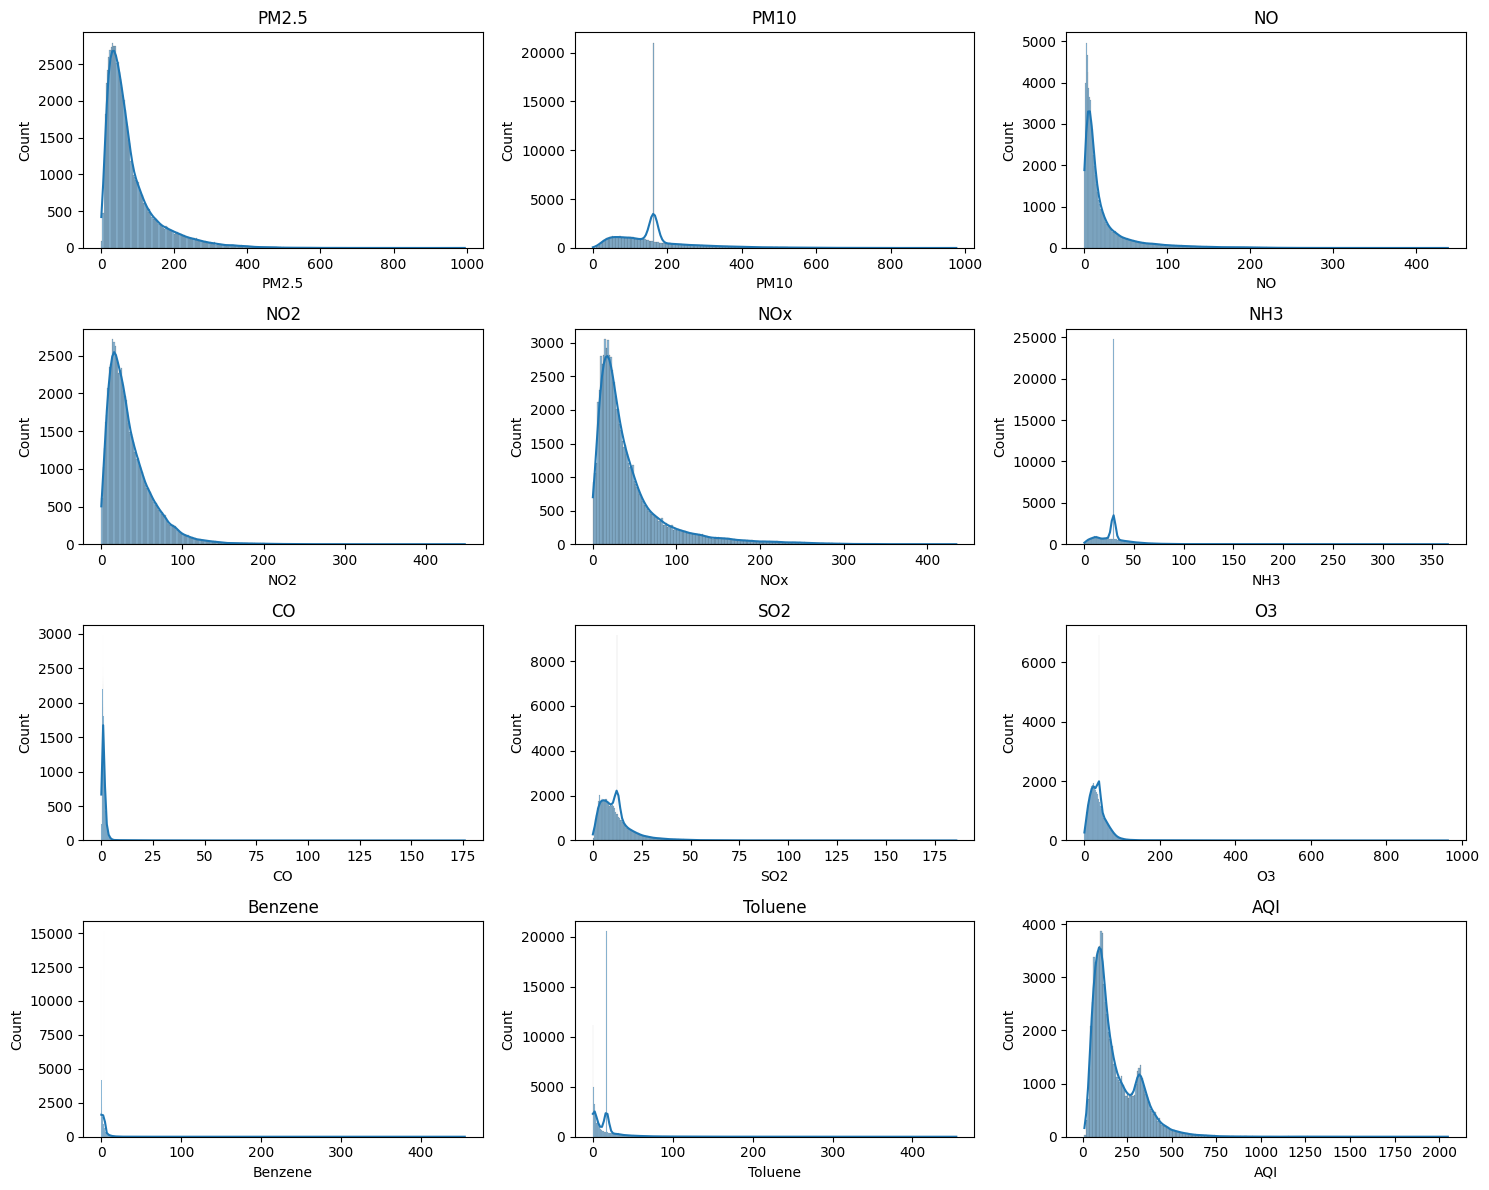

In [6]:
cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI']

plt.figure(figsize=(15, 12))

for i, col in enumerate(cols, 1):  # start index from 1 for subplot
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

## Observation:

Our dataset is extremely right skewed. (Data have mostly data points in left side.)

## Checking for Outliers

We are using **Boxplot** to check the Outliers in our dataset.

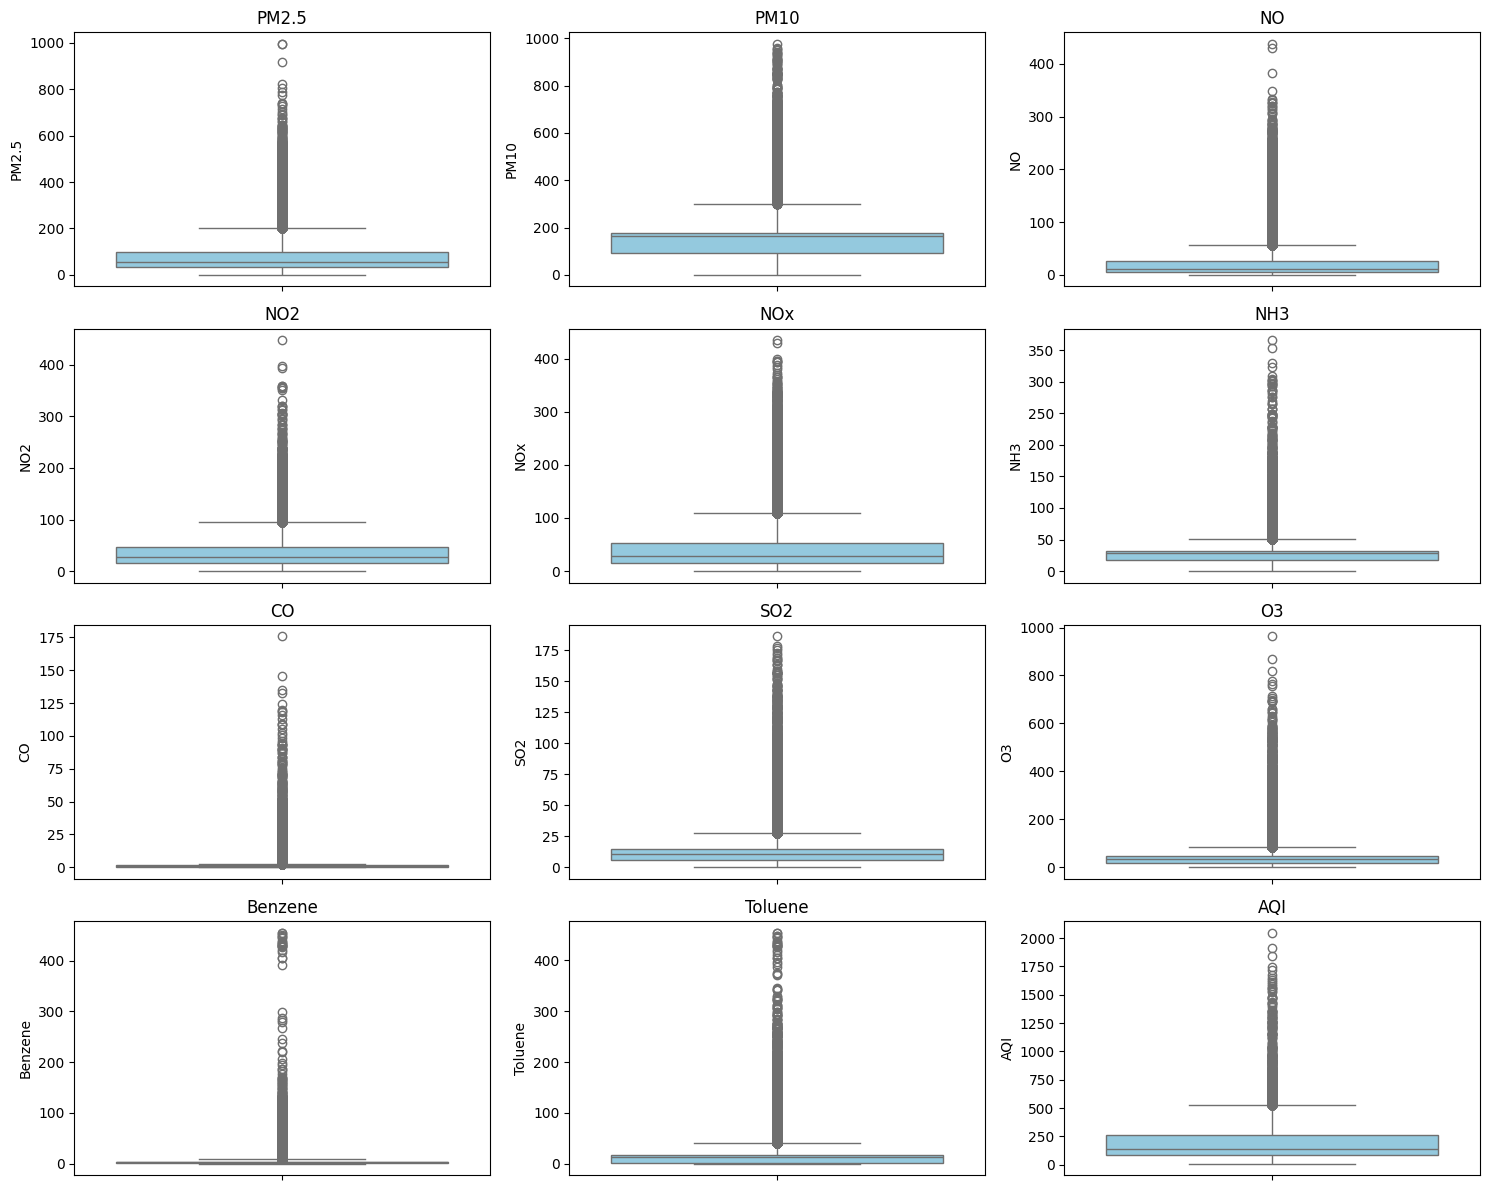

In [7]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=df, y=col, color='skyblue')  # y=col for vertical boxplot
    plt.title(col)

plt.tight_layout()
plt.show()

## Observation:
All of our features have Outliers in them which can be ovserved by rings over the **boxplot**.

## Approach:
Here we have capped using **InterQuartile Method** our outliers as we cannot afford to lose more data by removing them.

In [8]:
# 2nd Quadratile

q2_pm2=df['PM2.5'].quantile(0.25)
q2_pm10=df['PM10'].quantile(0.25)
q2_no=df['NO'].quantile(0.25)
q2_no2=df['NO2'].quantile(0.25)
q2_nox=df['NOx'].quantile(0.25)
q2_nh3=df['NH3'].quantile(0.25)
q2_co=df['CO'].quantile(0.25)
q2_so2=df['SO2'].quantile(0.25)
q2_o3=df['O3'].quantile(0.25)
q2_ben=df['Benzene'].quantile(0.25)
q2_tol=df['Toluene'].quantile(0.25)
q2_aqi=df['AQI'].quantile(0.25)

# 3rd quartile

q3_pm2=df['PM2.5'].quantile(0.75)
q3_pm10=df['PM10'].quantile(0.75)
q3_no=df['NO'].quantile(0.75)
q3_no2=df['NO2'].quantile(0.75)
q3_nox=df['NOx'].quantile(0.75)
q3_nh3=df['NH3'].quantile(0.75)
q3_co=df['CO'].quantile(0.75)
q3_so2=df['SO2'].quantile(0.75)
q3_o3=df['O3'].quantile(0.75)
q3_ben=df['Benzene'].quantile(0.75)
q3_tol=df['Toluene'].quantile(0.75)
q3_aqi=df['AQI'].quantile(0.75)

#Interquartlile Range

iqr_pm2=q3_pm2-q2_pm2
iqr_pm10=q3_pm10-q2_pm10
iqr_no=q3_no-q2_no
iqr_no2=q3_no2-q2_no2
iqr_nox=q3_nox-q2_nox
iqr_nh3=q3_nh3-q2_nh3
iqr_co=q3_co-q2_co
iqr_so2=q3_so2-q2_so2
iqr_o3=q3_o3-q2_o3
iqr_ben=q3_ben-q2_ben
iqr_tol=q3_tol-q2_tol
iqr_aqi=q3_aqi-q2_aqi

# Upper Limit

u_pm2=q3_pm2+ 1.5 *iqr_pm2
u_pm10=q3_pm10+ 1.5 *iqr_pm10
u_no=q3_no+ 1.5 *iqr_no
u_no2=q2_no2+ 1.5 *iqr_no2
u_nox=q3_nox+ 1.5 *iqr_nox
u_nh3=q3_nh3+ 1.5 *iqr_nh3
u_co=q3_co+ 1.5 *iqr_co
u_so2=q3_so2+ 1.5 *iqr_so2
u_o3=q3_o3+ 1.5 *iqr_o3
u_ben=q3_ben+ 1.5 *iqr_ben
u_tol=q3_tol+ 1.5 *iqr_tol
u_aqi=q3_aqi+ 1.5 *iqr_aqi

# Lower Limit

l_pm2=q3_pm2- 1.5 *iqr_pm2
l_pm10=q3_pm10- 1.5 *iqr_pm10
l_no=q3_no- 1.5 *iqr_no
l_no2=q2_no2- 1.5 *iqr_no2
l_nox=q3_nox-1.5 *iqr_nox
l_nh3=q3_nh3- 1.5 *iqr_nh3
l_co=q3_co- 1.5 *iqr_co
l_so2=q3_so2- 1.5 *iqr_so2
l_o3=q3_o3- 1.5 *iqr_o3
l_ben=q3_ben- 1.5 *iqr_ben
l_tol=q3_tol- 1.5 *iqr_tol
l_aqi=q3_aqi- 1.5 *iqr_aqi

# Capping

new_df_cap = df.copy()

new_df_cap['NO'] = np.where(
    new_df_cap['NO'] > u_no,
    u_no,
    np.where(
        new_df_cap['NO'] < l_no,
          l_no,
        new_df_cap['NO']
    )
)

new_df_cap['PM2.5'] = np.where(
    new_df_cap['PM2.5'] > u_pm2,
    u_pm2,
    np.where(
        new_df_cap['PM2.5'] < l_pm2,
          l_pm2,
        new_df_cap['PM2.5']
    )
)

new_df_cap['PM10'] = np.where(
    new_df_cap['PM10'] > u_pm10,
    u_pm10,
    np.where(
        new_df_cap['PM10'] < l_pm10,
          l_pm10,
        new_df_cap['PM10']
    )
)

new_df_cap['NO2'] = np.where(
    new_df_cap['NO2'] > u_no2,
    u_no2,
    np.where(
        new_df_cap['NO2'] < l_no2,
          l_no2,
        new_df_cap['NO2']
    )
)

new_df_cap['NOx'] = np.where(
    new_df_cap['NOx'] > u_nox,
    u_nox,
    np.where(
        new_df_cap['NOx'] < l_nox,
          l_nox,
        new_df_cap['NOx']
    )
)

new_df_cap['NH3'] = np.where(
    new_df_cap['NH3'] > u_nh3,
    u_nh3,
    np.where(
        new_df_cap['NH3'] < l_nh3,
          l_nh3,
        new_df_cap['NH3']
    )
)

new_df_cap['CO'] = np.where(
    new_df_cap['CO'] > u_co,
    u_co,
    np.where(
        new_df_cap['CO'] < l_co,
          l_co,
        new_df_cap['CO']
    )
)

new_df_cap['SO2'] = np.where(
    new_df_cap['SO2'] > u_so2,
    u_so2,
    np.where(
        new_df_cap['SO2'] < l_so2,
          l_so2,
        new_df_cap['SO2']
    )
)

new_df_cap['O3'] = np.where(
    new_df_cap['O3'] > u_o3,
    u_o3,
    np.where(
        new_df_cap['O3'] < l_o3,
          l_o3,
        new_df_cap['O3']
    )
)

new_df_cap['Benzene'] = np.where(
    new_df_cap['Benzene'] > u_ben,
    u_ben,
    np.where(
        new_df_cap['Benzene'] < l_ben,
          l_ben,
        new_df_cap['Benzene']
    )
)

new_df_cap['Toluene'] = np.where(
    new_df_cap['Toluene'] > u_tol,
    u_tol,
    np.where(
        new_df_cap['Toluene'] < l_tol,
          l_tol,
        new_df_cap['Toluene']
    )
)

new_df_cap['AQI'] = np.where(
    new_df_cap['AQI'] > u_aqi,
    u_aqi,
    np.where(
        new_df_cap['AQI'] < l_aqi,
          l_aqi,
        new_df_cap['AQI']
    )
)

## Comparing Before and after capping

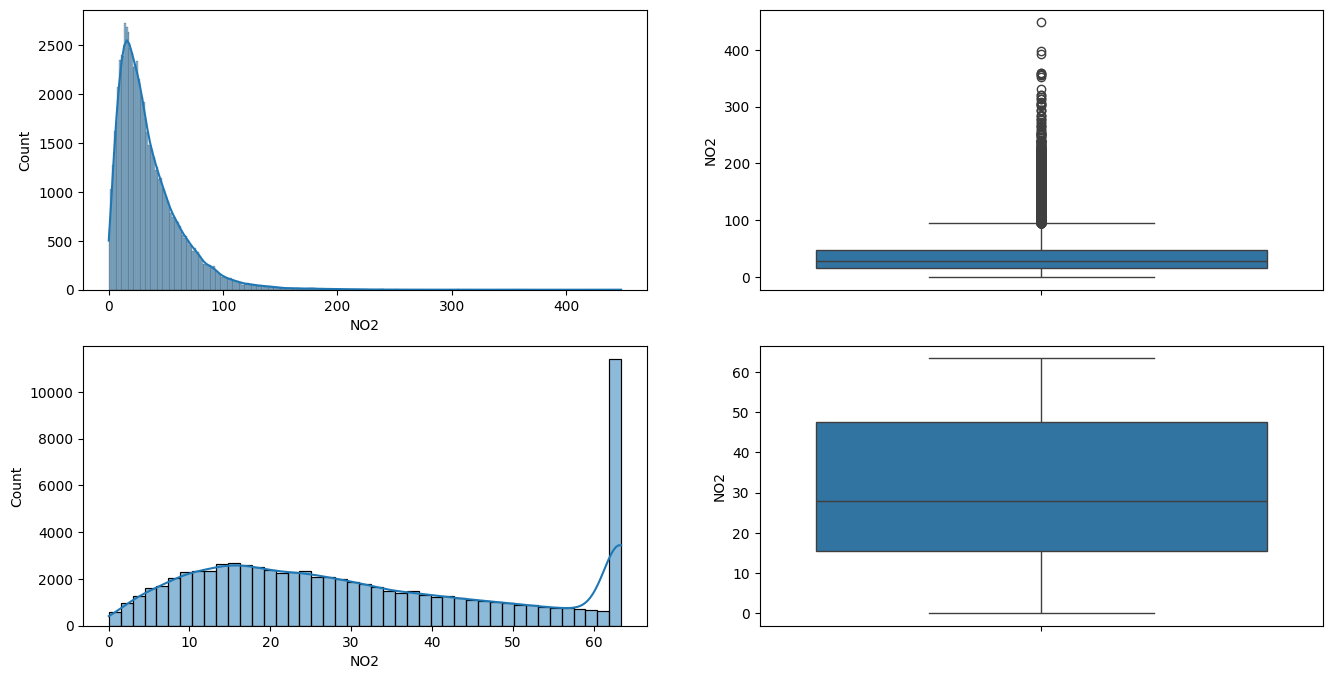

In [9]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(df['NO2'],kde=True)

plt.subplot(2,2,2)
sns.boxplot(df['NO2'])

plt.subplot(2,2,3)
sns.histplot(new_df_cap['NO2'],kde=True)

plt.subplot(2,2,4)
sns.boxplot(new_df_cap['NO2'])

plt.show()

## Observation:
1. Distribution of data is now better.
2. There are no more outliers left in our dataset.

## Checking outliers in rest of the features

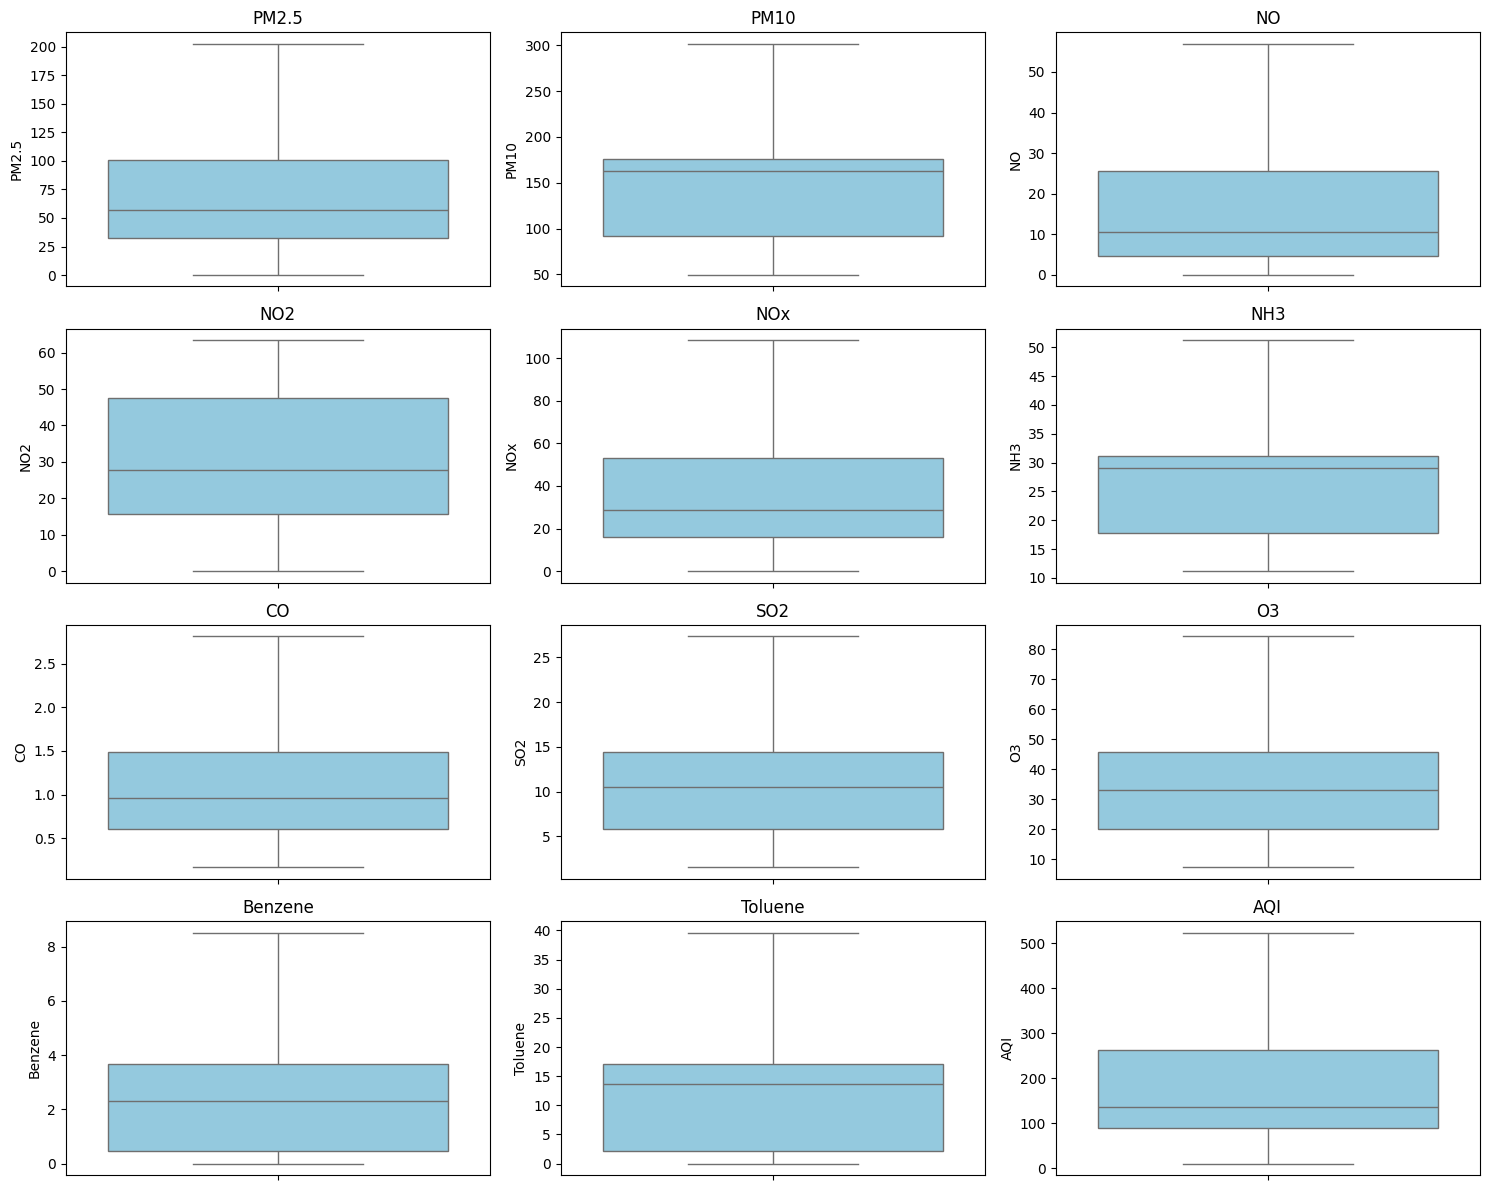

In [10]:

plt.figure(figsize=(15, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(data=new_df_cap, y=col, color='skyblue')  # y=col for vertical boxplot
    plt.title(col)

plt.tight_layout()
plt.show()

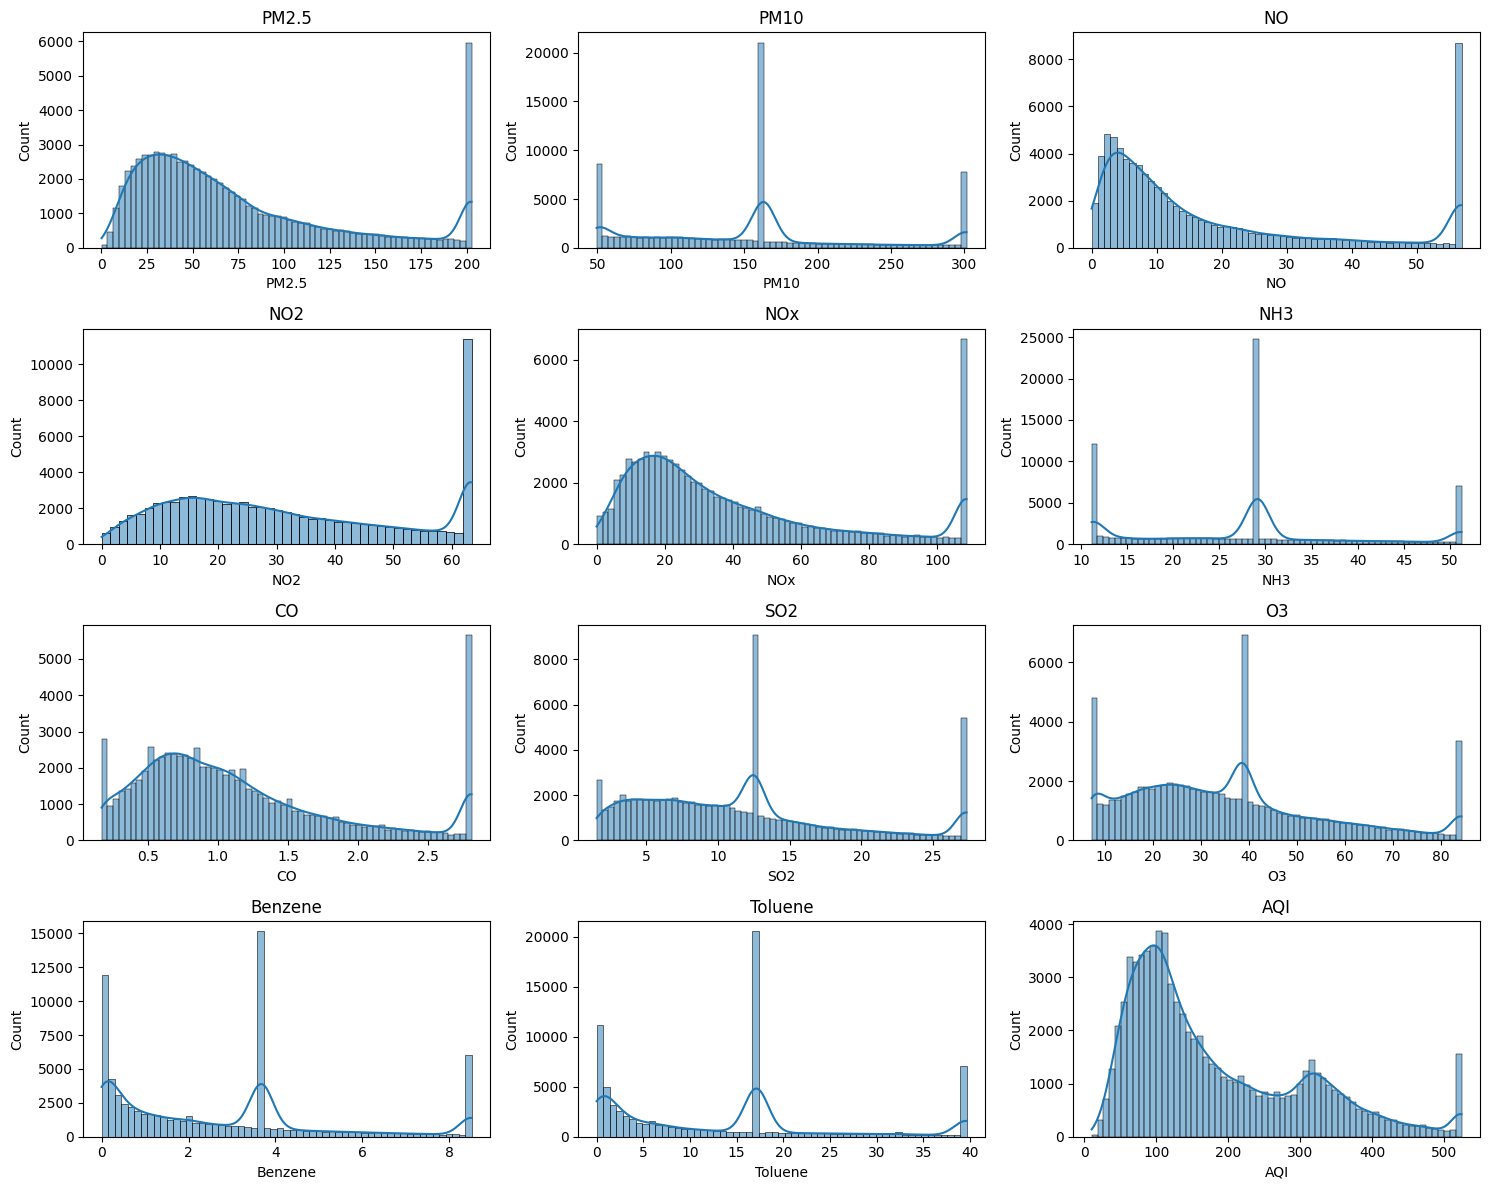

In [11]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(cols, 1):  # start index from 1 for subplot
    plt.subplot(4, 3, i)
    sns.histplot(new_df_cap[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

## Observation:
1. Some of the features like (**AQI, NOx, NO, PM2.5**) still right skewed.

## Approach:
1. Features seems to be mildly skewed, we will by transforming into **square root**.

In [12]:
new_df_cap[cols].skew()

PM2.5      1.060712
PM10       0.506075
NO         1.160726
NO2        0.368767
NOx        1.063757
NH3        0.383241
CO         0.956508
SO2        0.805489
O3         0.736296
Benzene    0.896872
Toluene    0.807516
AQI        0.997032
dtype: float64

## Observation:
1. Features like **PM2.5, NO, NOx** are strongly right skewed. (Will be transformed into **log**)
2. Features like **PM10, CO, SO2, O3, Benzene, Toluene, AQI** are mildly right skewed. (Will be transformed in **square root**)
3. Features like **NO2, NH3 don't need to be transformed.

In [13]:
strong_right_skewed=['PM2.5', 'NO', 'NOx']
mild_right_skewed=['PM10', 'CO', 'SO2', 'O3','Benzene','Toluene', 'AQI']
new_df_cap[strong_right_skewed] = np.log1p(new_df_cap[strong_right_skewed])
new_df_cap[mild_right_skewed] = np.sqrt(new_df_cap[mild_right_skewed])
new_df_cap[cols].skew()

PM2.5     -0.294090
PM10       0.033977
NO         0.013572
NO2        0.368767
NOx       -0.617604
NH3        0.383241
CO         0.370655
SO2        0.183177
O3         0.145855
Benzene   -0.028403
Toluene   -0.068455
AQI        0.511096
dtype: float64

**Now all the features are nomally distributed**

# Dataset seperation
1. We are going to use multiple algorithms like **RandomForest**, **XGBoost**, which do not require to handle **multicollinearity** but other model we are going to use like **SVM** and **LinearRegression (Stacking Model)** are sensitive the **multicollinearity**.

2. Creating two datasets one with **multicollinearity** and other without **multicollinerity**.

In [14]:
df_mc=new_df_cap.copy()
df_wmc=new_df_cap.copy()

# Dataset with Multicollinearity

# Feature Engineering

## Correlation

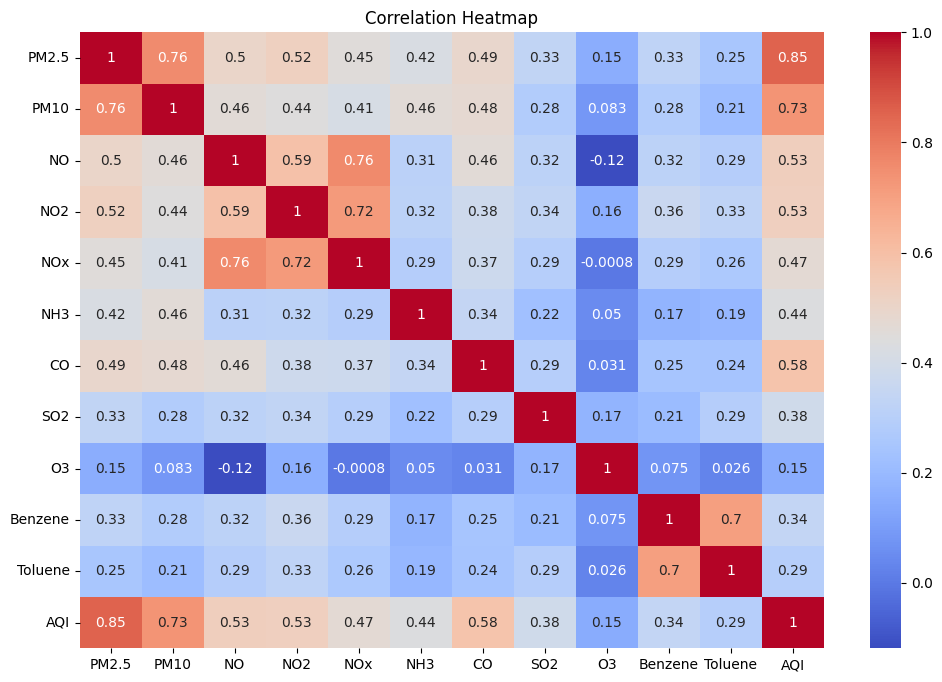

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_mc.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## Observation:
1. O3 will work as noise for our model because there is only 0.15 correlation with the **AQI**(Target variable) that's why we are removing O3.


In [16]:
df_mc=df_mc.drop(['O3'],axis=1)

# VIF (Varience Inflation Factor)

In [17]:
# Importing Varience Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_x =df_mc.drop('AQI', axis=1).select_dtypes(include='number')

# Create VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = vif_x.columns
vif_data["VIF"] = [variance_inflation_factor(vif_x.values, i) for i in range(vif_x.shape[1])]

print(vif_data)

   feature        VIF
0    PM2.5  57.151148
1     PM10  41.248598
2       NO  18.713439
3      NO2   6.922779
4      NOx  36.407706
5      NH3   8.585189
6       CO  15.843590
7      SO2  12.204512
8  Benzene   7.851437
9  Toluene   7.947740


# Observation and Approach
1. PM2.5, PM10 are **extremly multicollinear**, we have to **remove PM10** as PM2.5 have higher correlation with **AQI** than **PM10**.
2. We have to remove **NOx, NO** as they are **extreamly collinear**.

In [18]:
df_mc=df_mc.drop(['PM10','NOx','NO'],axis=1)

In [19]:
X = df_mc.select_dtypes(include='number')
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

   feature        VIF
0    PM2.5  42.808322
1      NO2   5.527481
2      NH3   8.236552
3       CO  15.585946
4      SO2  11.872162
5  Benzene   7.815952
6  Toluene   7.921347
7      AQI  32.712225


## Observation
All the **multicollinear** features has been handled.

# Preparing dataset
Using **train_test_split_** for fitting models

In [20]:
# Dataset with handled multicollinearity
x_mc = df_mc.drop(columns=['AQI','StationId', 'Date','AQI_Bucket']) 
y_mc = df_mc['AQI'] 
x_train_mc, x_test_mc, y_train_mc, y_test_mc=train_test_split(x_mc,y_mc,random_state=42,test_size=0.2)

# Dataset without handling multicollinearity
x_wmc = df_wmc.drop(columns=['AQI','StationId', 'Date','AQI_Bucket']) 
y_wmc = df_wmc['AQI'] 
x_train_wmc, x_test_wmc, y_train_wmc, y_test_wmc=train_test_split(x_wmc,y_wmc,random_state=42,test_size=0.2)

# Preparing models using Pipeline

In [21]:
# RandomForest
model_random=RandomForestRegressor(n_estimators=100,random_state=42)

In [22]:
# SVM
model_svm= make_pipeline(StandardScaler(), SVR(kernel='linear'))

In [23]:
# XGBoost
model_xgboost = xg.XGBRegressor(objective='reg:squarederror', n_estimators = 100, seed = 42)

In [24]:
# Ensemble Stacking model of RandomForest, SVM, XGBoost with LinearRegressor as meta model
base_models = [
    ('xgb', model_xgboost),
    ('rf', model_random),
    ('svm', model_svm)
]
meta_model = LinearRegression()
model_ensemble = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# Cross Validation

In [25]:
# Defining Scorer
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

In [27]:
# RandomForest
results = cross_validate(
    model_random,
    x_train_wmc,
    y_train_wmc,
    cv=5,
    scoring=scoring,
    return_train_score=False)
rmse_scores_rf = -results["test_rmse"]  
r2_scores_rf = results["test_r2"]

print("Random Forest Results")
print("-----------------------------------")
print("RMSE scores:", rmse_scores_rf)
print("Average RMSE:", rmse_scores_rf.mean())
print("R2 scores:", r2_scores_rf)
print("Average R2 (%):", r2_scores_rf.mean() * 100)

Random Forest Results
-----------------------------------
RMSE scores: [1.17071263 1.16504515 1.17089572 1.17345368 1.17940823]
Average RMSE: 1.1719030837312894
R² scores: [0.92502774 0.92637214 0.92643324 0.92641122 0.92499919]
Average R² (%): 92.58487069563222


## Observation
1. We are getting a average **root mean squared error** of **1.171** which means there is only average error of 1.171 whlile **Cross Validation** on 5 folds.
2. On observing **R2 scores**, we can conclude that we are getting accuracy of **92.58%**.

In [28]:
# XGBoost
results = cross_validate(
    model_xgboost,
    x_train_wmc,
    y_train_wmc,
    cv=5,
    scoring=scoring,
    return_train_score=False)
rmse_scores_xg = -results["test_rmse"]  
r2_scores_xg = results["test_r2"]

print("XGBoost Results")
print("-----------------------------------")
print("RMSE scores:", rmse_scores_xg)
print("Average RMSE:", rmse_scores_xg.mean())
print("R2 scores:", r2_scores_xg)
print("Average R2 (%):", r2_scores_xg.mean() * 100)

XGBoost Results
-----------------------------------
RMSE scores: [1.18876458 1.18704177 1.19284916 1.1902426  1.19704998]
Average RMSE: 1.1911896172293868
R² scores: [0.92269783 0.92356564 0.92364873 0.92429045 0.92273867]
Average R² (%): 92.33882620825447


## Observation
1. We are getting a average **root mean squared error** of **1.191** which means there is only average error of 1.191 whlile **Cross Validation** on 5 folds.
2. On observing **R2 scores**, we can conclude that we are getting accuracy of **92.33%**, which is quite low from the **RandomForest**.

In [29]:
# SVM
results = cross_validate(
    model_svm,
    x_train_mc,
    y_train_mc,
    cv=5,
    scoring=scoring,
    return_train_score=False)
rmse_scores_svm = -results["test_rmse"]  
r2_scores_svm = results["test_r2"]

print("SVM Results")
print("-----------------------------------")
print("RMSE scores:", rmse_scores_svm)
print("Average RMSE:", rmse_scores_svm.mean())
print("R2 scores:", r2_scores_svm)
print("Average R2 (%):", r2_scores_svm.mean() * 100)

SVM Results
-----------------------------------
RMSE scores: [2.06139801 2.06641937 2.08127767 2.05740432 2.08641055]
Average RMSE: 2.070581983818559
R² scores: [0.76755313 0.76837066 0.76756301 0.77378625 0.76528699]
Average R² (%): 76.8512007497304


## Observation
1. We are getting a average **root mean squared error** of **2.070** which means there is only average error of 2.070 whlile **Cross Validation** on 5 folds.
2. On observing **R2 scores**, we can conclude that we are getting accuracy of **76.85%**, which is too low from the **RandomForest** and **XGBoost**.

In [30]:
# Ensemble Stacking model
results = cross_validate(
    model_ensemble,
    x_train_wmc,
    y_train_wmc,
    cv=5,
    scoring=scoring,
    return_train_score=False)
rmse_scores_en = -results["test_rmse"]  
r2_scores_en = results["test_r2"]

print("Random Forest Results")
print("-----------------------------------")
print("RMSE scores:", rmse_scores_en)
print("Average RMSE:", rmse_scores_en.mean())
print("R2 scores:", r2_scores_en)
print("Average R2 (%):", r2_scores_en.mean() * 100)

Random Forest Results
-----------------------------------
RMSE scores: [1.1558996  1.1510094  1.15757315 1.15727383 1.16322909]
Average RMSE: 1.1569970136799181
R² scores: [0.92691299 0.9281355  0.92809782 0.92842655 0.9270428 ]
Average R² (%): 92.77231312263001


## Observation
1. We are getting a average **root mean squared error** of **1.156** which means there is only average error of 1.156 whlile **Cross Validation** on 5 folds.
2. On observing **R2 scores**, we can conclude that we are getting accuracy of **92.77%**, which is best among all models.

# Fitting the Model

In [32]:
model_random.fit(x_train_wmc,y_train_wmc)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [33]:
model_svm.fit(x_train_mc,y_train_mc)

,steps,"[('standardscaler', ...), ('svr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0


In [34]:
model_xgboost.fit(x_train_wmc,y_train_wmc)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [35]:
model_ensemble.fit(x_train_mc, y_train_mc)

,estimators,"[('xgb', ...), ('rf', ...), ...]"
,final_estimator,LinearRegression()
,cv,5
,n_jobs,None
,passthrough,False
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


# Mesures of the models

In [36]:
# Random forest
y_random = model_random.predict(x_test_wmc)

mae = mean_absolute_error(y_test_wmc, y_random)
mse = mean_squared_error(y_test_wmc, y_random)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_wmc, y_random)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Score (R²):", r2)
r2 = r2_score(y_test_wmc, y_random)
accuracy_percent = r2 * 100
print(f"Model Accuracy: {accuracy_percent:.2f}%")

Mean Absolute Error (MAE): 0.8019842295084825
Mean Squared Error (MSE): 1.3727483547953312
Root Mean Squared Error (RMSE): 1.1716434418351562
R-squared Score (R²): 0.9266628301254195
Model Accuracy: 92.67%


## Observation
1. On an average model's prediction differs with **0.80** units from the actual value as it is the **Mean Absolute Error**.
2. **Mean Squared Error** with a value of **1.37** indicates there are **no big outliers** or **big wrong prediction**.
3. **Root Mean Squared Error** with value of **1.171** shows that **model's prediction error** is **1.171 units**.
4. **R2** shows that model have **92.67%** of variability.

In [37]:
# SVM
y_svm = model_svm.predict(x_test_mc)

mae = mean_absolute_error(y_test_mc, y_svm)
mse = mean_squared_error(y_test_mc, y_svm)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_mc, y_svm)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Score (R²):", r2)
r2 = r2_score(y_test_mc, y_svm)
accuracy_percent = r2 * 100
print(f"Model Accuracy: {accuracy_percent:.2f}%")

Mean Absolute Error (MAE): 1.5590476828508015
Mean Squared Error (MSE): 4.286166128370615
Root Mean Squared Error (RMSE): 2.070305805520193
R-squared Score (R²): 0.7710175412930256
Model Accuracy: 77.10%


## Observation
1. On an average model's prediction differs with **1.55 units** from the actual value as it is the **Mean Absolute Error**.
2. **Mean Squared Error** with a value of **4.26** indicates model have more errors than the previous model.
3. **Root Mean Squared Error** with value of **2.070** shows that **model's prediction error** is **2.070 units**.
4. **R2** shows that model have **77.10%** of variability.

In [38]:
# XGBoost
y_xgboost = model_xgboost.predict(x_test_wmc)

mae = mean_absolute_error(y_test_wmc, y_xgboost)
mse = mean_squared_error(y_test_wmc, y_xgboost)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_wmc, y_xgboost)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Score (R²):", r2)
r2 = r2_score(y_test_wmc, y_xgboost)
accuracy_percent = r2 * 100
print(f"Model Accuracy: {accuracy_percent:.2f}%")

Mean Absolute Error (MAE): 0.8244808548117655
Mean Squared Error (MSE): 1.4294884739293203
Root Mean Squared Error (RMSE): 1.1956121753851958
R-squared Score (R²): 0.9236315682476708
Model Accuracy: 92.36%


## Observation
1. On an average model's prediction differs with **0.82 units** from the actual value as it is the **Mean Absolute Error**.
2. **Mean Squared Error** with a value of **1.42** indicates model is better than previous model still not the best.
3. **Root Mean Squared Error** with value of **1.195** shows that **model's prediction error** is **1.195 units**.
4. **R2** shows that model have **92.36%** of variability.

In [39]:
# Ensemble Learning
y_ensemble = model_ensemble.predict(x_test_mc)

mae = mean_absolute_error(y_test_mc, y_ensemble)
mse = mean_squared_error(y_test_mc, y_ensemble)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_mc, y_ensemble)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Score (R²):", r2)
r2 = r2_score(y_test_mc, y_ensemble)
accuracy_percent = r2 * 100
print(f"Model Accuracy: {accuracy_percent:.2f}%")

Mean Absolute Error (MAE): 1.0336727067248075
Mean Squared Error (MSE): 2.13601260068778
Root Mean Squared Error (RMSE): 1.4615103833663927
R-squared Score (R²): 0.8858865003161925
Model Accuracy: 88.59%


## Observation
1. On an average model's prediction differs with **1.03 units** from the actual value as it is the **Mean Absolute Error**.
2. **Mean Squared Error** with a value of **2.13** indicates model performs average among rest of the model.
3. **Root Mean Squared Error** with value of **0.88** shows that **model's prediction error** is **0.88 units**.
4. **R2** shows that model have **88.59%** of variability.

# Plot Residuals

## 1. Residuals vs Predicted
- Detects non-linear patterns  
- Shows heteroscedasticity  
- Residuals should be randomly scattered around zero  

## 2. Residual Distribution
- Shows error distribution  
- Should be centered around zero  
- Closer to bell-shaped = better  

## 3. Q-Q Plot
- Checks normality of residuals  
- Points close to diagonal → good  

## 4. Actual vs Predicted
- Shows how close predictions are to actual values  
- Points near diagonal → high accuracy  


In [41]:
def plot_residual_analysis(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(16,10))

    # 1. Residuals vs Predicted
    plt.subplot(2,2,1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted Values")

    # 2. Residual Distribution
    plt.subplot(2,2,2)
    sns.histplot(residuals, bins=30, kde=True)
    plt.xlabel("Residuals")
    plt.title("Residuals Distribution")

    # 3. QQ Plot
    plt.subplot(2,2,3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("QQ Plot of Residuals")

    # 4. Actual vs Predicted
    plt.subplot(2,2,4)
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

    plt.tight_layout()
    plt.show()


## RandomForest

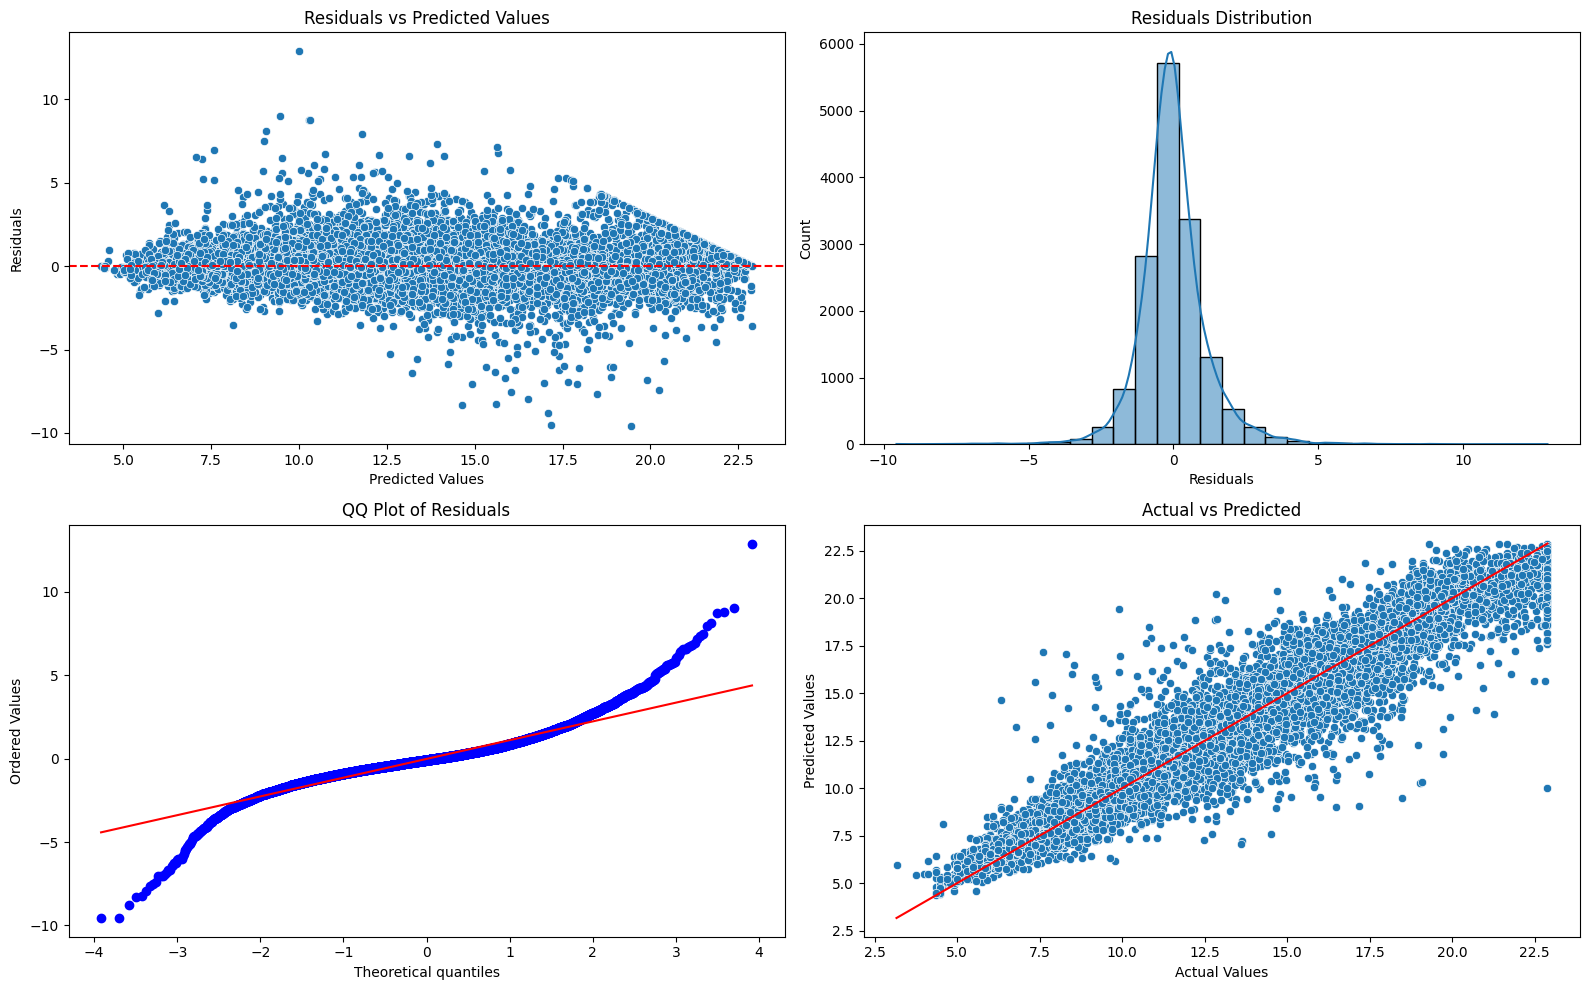

In [42]:
plot_residual_analysis(y_test_wmc, y_random)

## XGBoost

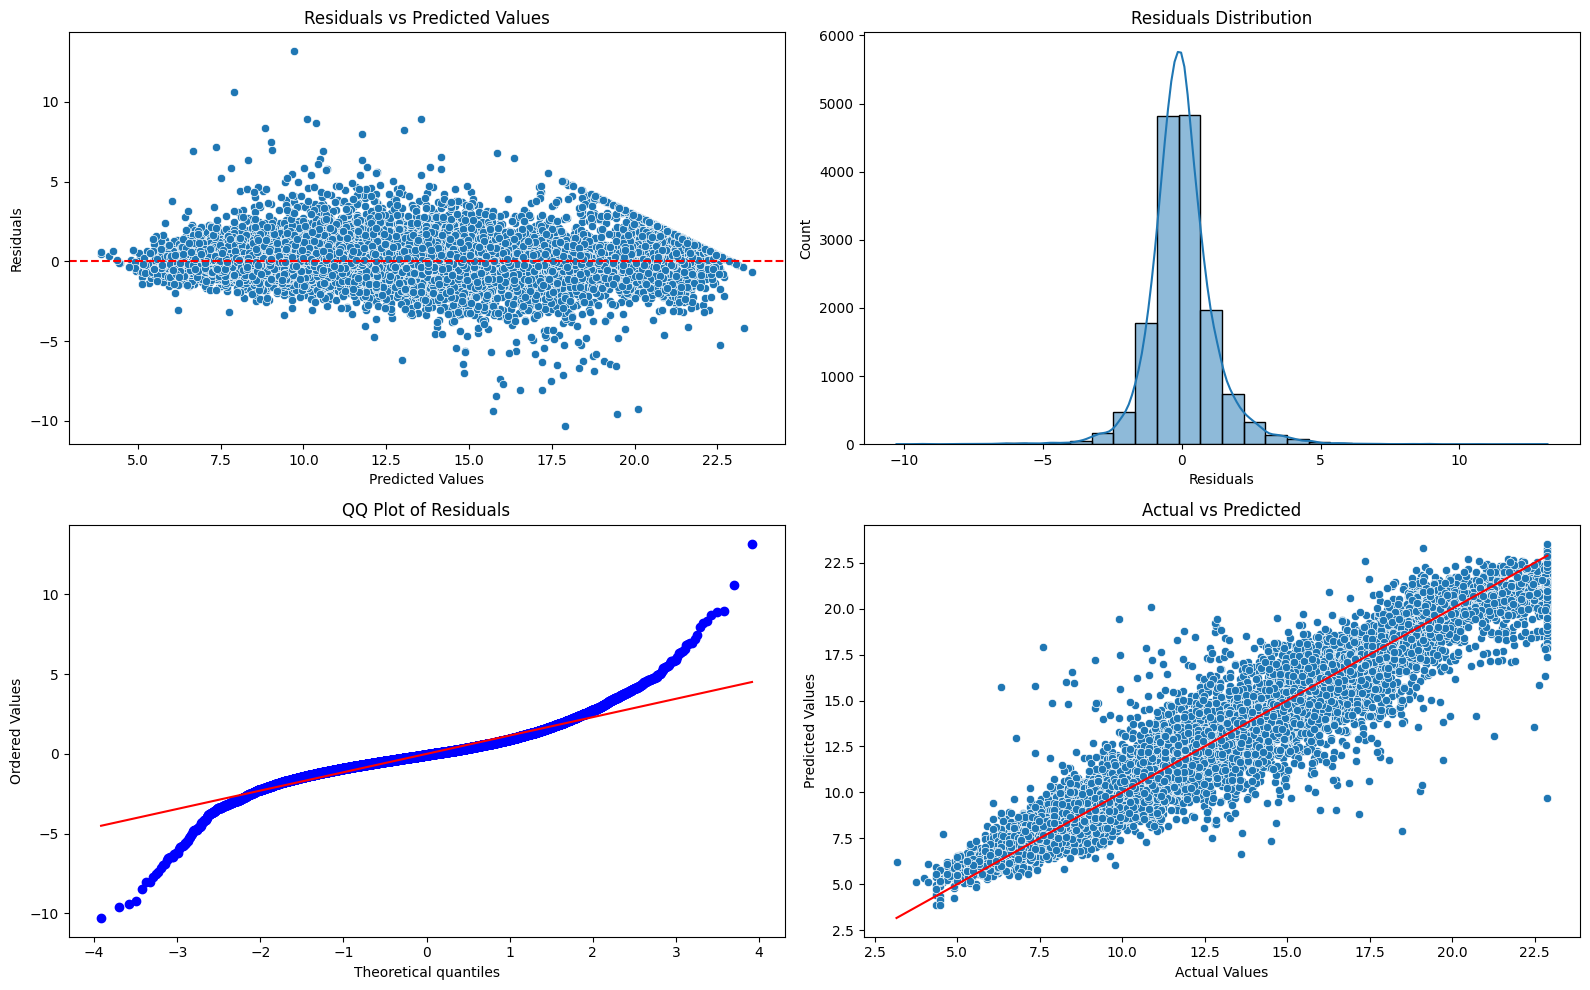

In [43]:
plot_residual_analysis(y_test_wmc, y_xgboost)

## SVM

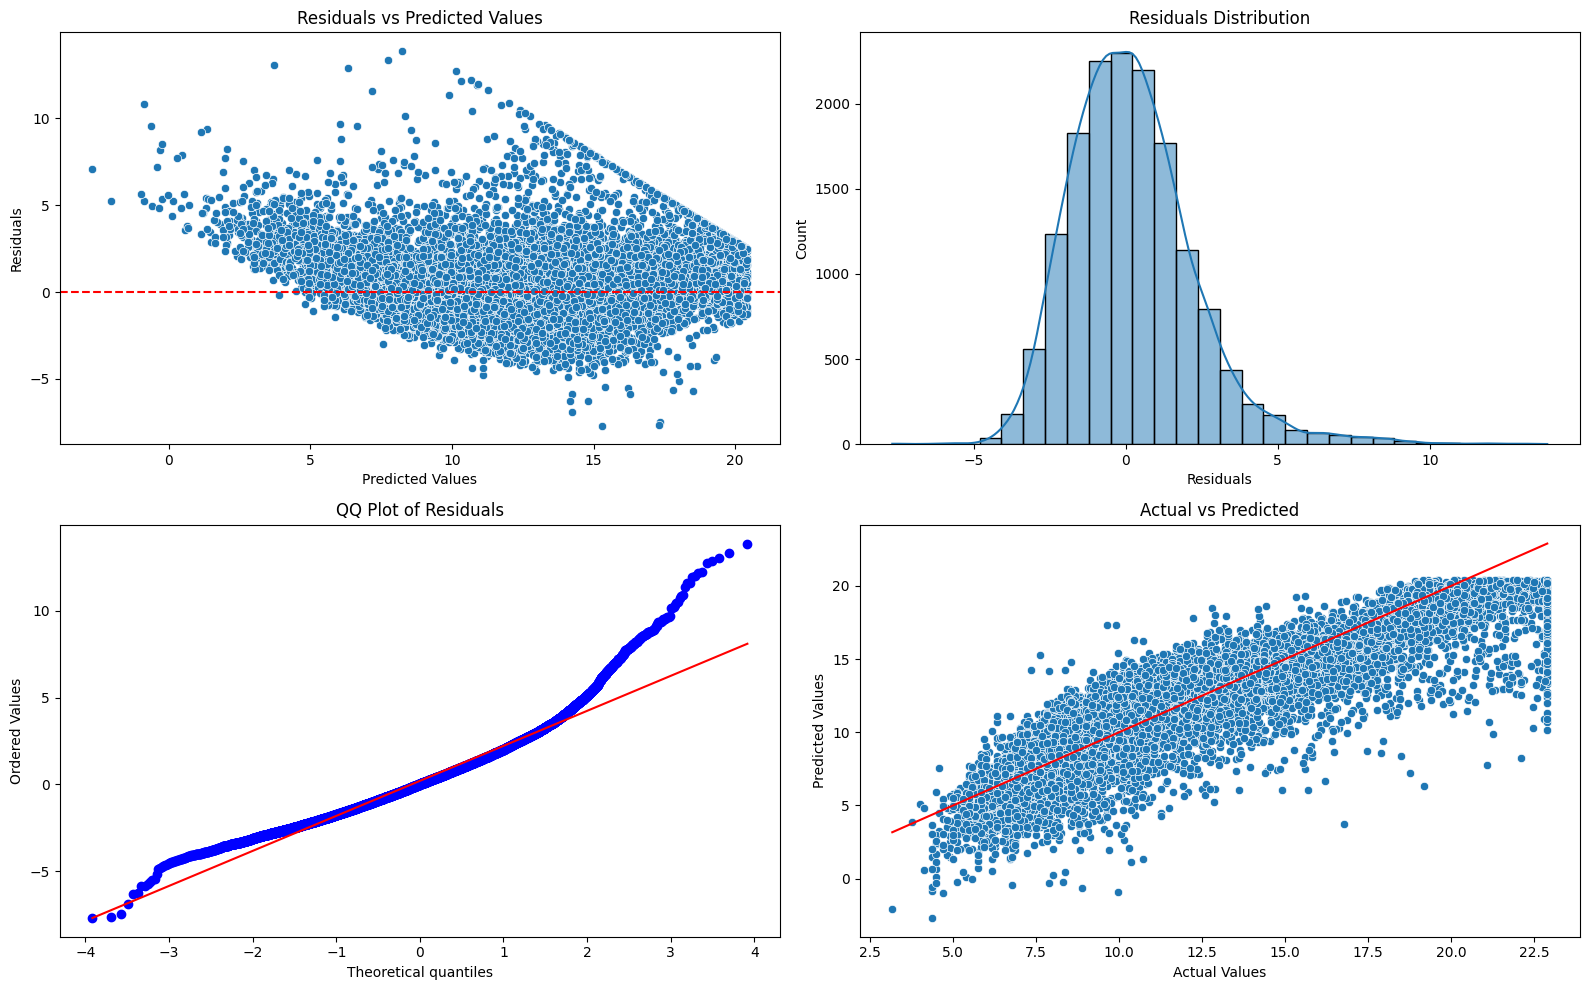

In [44]:
plot_residual_analysis(y_test_mc, y_svm)

## Ensemble Stacking Model

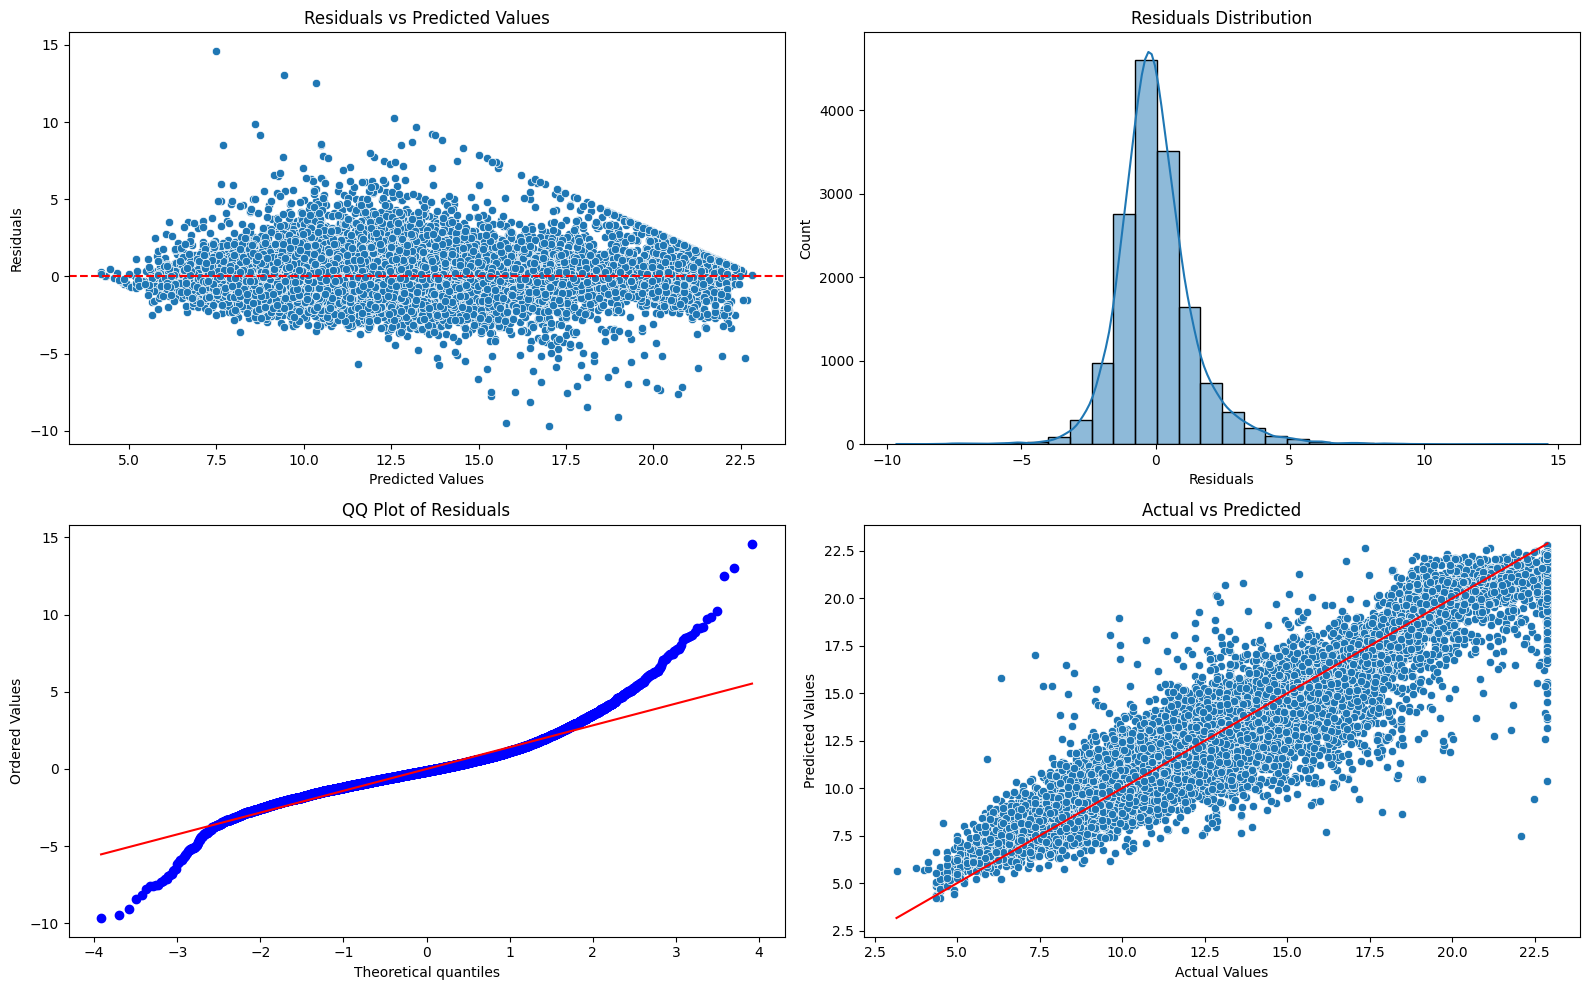

In [45]:
plot_residual_analysis(y_test_mc, y_ensemble)

In [46]:
import pickle

In [47]:
with open("model_random.pkl", "wb") as file:
    pickle.dump(model_random, file)

In [48]:
with open("model_svm.pkl", "wb") as file:
    pickle.dump(model_svm, file)

In [49]:
with open("model_xgboost.pkl", "wb") as file:
    pickle.dump(model_xgboost, file)

In [50]:
with open("model_ensemble.pkl", "wb") as file:
    pickle.dump(model_ensemble, file)

# Final Conclusion

In this project, I completed the full workflow of AQI prediction starting from cleaning the data to building the final model. First, I handled all the important preprocessing steps like removing outliers, fixing right-skewed features using log transformation, checking correlations, and handling multicollinearity using VIF. Based on VIF values, I removed PM10 and NOx because they were highly collinear, which helped make the dataset more stable for sensitive models like SVM.

After preprocessing, I created two datasets: one with multicollinearity handled and one without it. Then I trained multiple ML models such as Random Forest, XGBoost, and SVM, and also built a stacking model. Among all the models, Random Forest performed the best, giving the following results:

MAE ≈ 0.80
RMSE ≈ 1.37
RMSE ≈ 1.171

R² ≈ 0.9266

Accuracy ≈ 92.67%

These values show that the model is predicting AQI very accurately and the errors are quite low. R² around 0.92 means the model is explaining almost 92.67% of the variation in the target. I also plotted residuals, and the plots clearly show that the errors are randomly spread, which means the model is stable and not biased.

Overall, this project helped me understand the complete process of building a machine learning model—from preprocessing, feature selection, handling multicollinearity, training different models, evaluating them, and finally choosing the best one. The final AQI prediction model is reliable and good enough to use in real applications like forecast dashboards or environmental monitoring systems.

This project really improved my ML skills, especially in data cleaning, model evaluation, and understanding how different algorithms behave with different types of data.